# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install opencv-python opencv-python-headless
!python -m pip install opencv-contrib-python
!python -m pip install scipy
!python -m pip install scikit-learn

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import stats
from sklearn.cluster import DBSCAN

## Data set

In [7]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# verify by checking the last 5 rows of the data (year/month should be 2005, 24)
df.tail()

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,...,flag.4,flag.5,dt.start,dt.peak,dt.end,year,month,day,energy.kev.i,energy.kev.f
17501,704,24,72312.0,6-12,-279,229,362,841,A0,DF,...,P1,Q2,2005-12-29 21:38:40,2005-12-29 21:39:50,2005-12-29 21:50:24,2005,12,29,6,12
17502,212,22,24624.0,6-12,-402,238,468,841,A0,DF,...,Q1,NaN,2005-12-29 22:07:16,2005-12-29 22:08:18,2005-12-29 22:10:48,2005,12,29,6,12
17503,584,184,332976.0,6-12,-251,243,350,843,A0,GD,...,GS,P1 PE Q4,2005-12-30 16:47:04,2005-12-30 16:50:02,2005-12-30 16:56:48,2005,12,30,6,12
17504,512,56,101424.0,6-12,-250,228,339,0,A0,P1,...,Q1,NaN,2005-12-30 20:18:20,2005-12-30 20:21:22,2005-12-30 20:26:52,2005,12,30,6,12
17505,292,18,25416.0,6-12,879,-216,906,844,A0,DF,...,Q1,NaN,2005-12-30 21:49:12,2005-12-30 21:49:30,2005-12-30 21:54:04,2005,12,30,6,12


## Design and implement a hotspot discovery algorithm 

In [17]:
def hotspot_detection(d1, d2, df):
    # Define the grid size based on the X and Y position ranges
    x_min = df['x.pos.asec'].min()
    x_max = df['x.pos.asec'].max()
    y_min = df['y.pos.asec'].min()
    y_max = df['y.pos.asec'].max()
    grid_resolution = 1

    x_range = np.arange(x_min, x_max, grid_resolution)
    y_range = np.arange(y_min, y_max, grid_resolution)

    # Create an empty intensity map
    intensity_map = np.zeros((len(y_range), len(x_range)))

    # calculate intensity values
    for index, row in df.iterrows():
        x = row['x.pos.asec']
        y = row['y.pos.asec']
        intensity = row['energy.kev.f']

        # Find the corresponding grid cell for the X and Y positions
        x_cell = np.digitize(x, x_range) - 1
        y_cell = np.digitize(y, y_range) - 1

        # Assign the intensity value to the corresponding grid cell
        intensity_map[y_cell, x_cell] += intensity 

    # Find hotspots above d1
    hotspots_d1 = np.where(intensity_map >= d1)

    # Find large regional hotspots above d2
    hotspots_d2 = np.where(intensity_map >= d2)

    # Create a binary mask for hotspots
    hotspot_mask_d1 = np.zeros_like(intensity_map, dtype=np.uint8)
    hotspot_mask_d2 = np.zeros_like(intensity_map, dtype=np.uint8)

    # 255 in hotspot, 0 not in hotspot
    hotspot_mask_d1[hotspots_d1] = 255 
    hotspot_mask_d2[hotspots_d2] = 255

    # Find contours in the binary mask
    contours_d1, _ = cv2.findContours(hotspot_mask_d1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_d2, _ = cv2.findContours(hotspot_mask_d2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # display plot
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots()

    # Display the intensity map
    ax.imshow(intensity_map, cmap='viridis', extent=[x_min, x_max, y_min, y_max])

    # Display the hotspots above d2
    for contour in contours_d2:
        x, y = zip(*contour.reshape(-1, 2))
        ax.scatter(x, y, color='blue', s=10) 

    # Display the hotspots above d1
    for contour in contours_d1:
        x, y = zip(*contour.reshape(-1, 2))
        ax.scatter(x, y, color='red', s=10)

    plt.show()



## Determine intensity threshold d1 and d2 for Method1, based on your results for Task1 

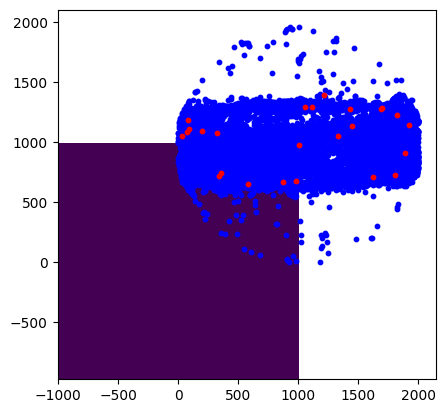

In [18]:
d1 = 300
d2 = 6

hotspot_detection(d1, d2, df)


## Create a method to visualize hotspots